In [3]:
import time
import numpy as np
import picos as pic
import matplotlib.pyplot as plt
from scipy.io import mmread
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm, trange
import warnings
warnings.filterwarnings('ignore')

# generate random graph

# n = 3
# p = .5
# np.random.seed(3)
# A = (np.random.rand(n, n) > p).astype(float)
# for i in range(n): 
#     A[i, i] = 0
# for i in range(n): 
#     for j in range(i): 
#         A[i, j] = A[j, i]

solver = 'mosek'
verbosity = False
A = mmread('graphs/hamming6-4.mtx')
n = A.shape[0]
print("n = {n}".format(n=n))
D = np.diag(np.sum(A, axis=int(0)))
L = (D - A)#.astype(float)
L = np.array(L)
L
C = L/4

n = 64


In [4]:
def optimize_over_elliptope(C):
    maxcut_problem = pic.Problem()
    # Variables
    X = pic.SymmetricVariable("X", shape=int(n))

    ## Objective
    maxcut_problem.set_objective('max', (C|X))

    ## Constraints
    # X psd
    maxcut_problem.add_constraint(X >> int(0))
    # 1 on the diagonal
    maxcut_problem.add_constraint(pic.maindiag(X) == int(1))

    maxcut_problem.solve()

    return maxcut_problem.value, np.array(X.value)

#np.random.seed(0)
#C = np.random.randn(3, 3)
obj_value, opt_solution = optimize_over_elliptope(C)
obj_value

22175.999999472868

In [39]:
from scipy import linalg


def dot_matrix(A, B):
    """ 
    Returns Tr(A @ B.T).
    """
    assert A.shape == B.shape
    return np.dot(A.flatten(), B.flatten())
    
    
    
def proj_linear_eq(G, A, b):
    """
    Solves the least-squares problem
    min ||X - G|| s.t. A(X) = b    """
    
#     # todo: make less hardcoded
#     G = G.copy()
#     for i in range(len(G)):
#         G[i, i] = 1.
#     A = A[-1:]
#     b = b[-1:]
    
    least_squares = pic.Problem()

    n = len(A[0])
    # Variables
    X = pic.SymmetricVariable("X", shape=int(n))

    # objective
    least_squares.set_objective('Min', pic.norm(X - G))
    
    ## Constraints
    for Ai, bi in zip(A, b):
        least_squares.add_constraint(Ai | X == bi)

    least_squares.solve(solver=solver, verbosity=verbosity)
    
    return np.array(X.value)

def proj_psd_cone(X):
    s, Q = np.linalg.eig(X)
    sigma = np.diag(np.maximum(s, 0))
    return Q @ sigma @ Q.T
    
def alternate_proj_sdp_solver(A, b, X0, num_iters, 
                              X_history=None, 
                              Y_history=None):
    """
    Solves the SDP feasibility Ai.X = bi, X psd using alternative projection
    Args:
    A: mxnxn tensor: List of matrices Ai
    b: mx1 vector of the same size as A
    X0: nxn matrix. Intial iteration feasible solution
    """
    
    Xk = X0
    Yk = None
    for k in trange(num_iters):
        Yk = proj_linear_eq(Xk, A, b)
        Xk = proj_psd_cone(Yk)

        # save X_current
        if X_history != None:
            X_history.append(Xk)
            Y_history.append(Yk)
            
    return Xk

In [51]:
# prepare data
canonical_basis = np.eye(n)
A = np.array([*[ei[:,None] @  ei[None, :] for ei in tqdm(canonical_basis)], C])
b = np.array([*np.ones(n), 10*obj_value])

In [52]:
np.random.seed(0)
X0 = np.random.randn(*A[0].shape)
X_history = []
Y_history = []
alternate_proj_sdp_solver(A, b, X0, 100, X_history, Y_history)

array([[10.00216026, 10.00339405, 10.00129427, ..., 10.00057969,
        10.00280081, 10.00109004],
       [10.00339405, 10.00462799, 10.00252796, ..., 10.00181329,
        10.00403468, 10.0023237 ],
       [10.00129427, 10.00252796, 10.00042836, ...,  9.99971384,
        10.00193477, 10.00022415],
       ...,
       [10.00057969, 10.00181329,  9.99971384, ...,  9.99899938,
        10.00122015,  9.99950965],
       [10.00280081, 10.00403468, 10.00193477, ..., 10.00122015,
        10.00344141, 10.00173053],
       [10.00109004, 10.0023237 , 10.00022415, ...,  9.99950965,
        10.00173053, 10.00001995]])

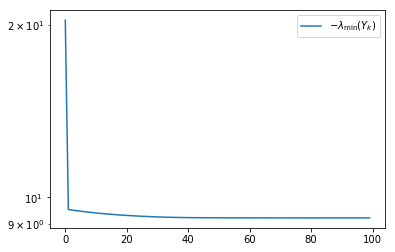

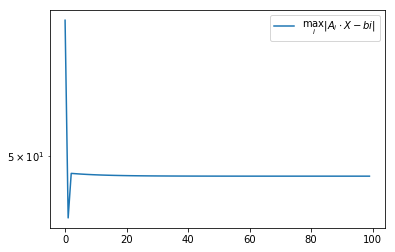

In [53]:
lmap = lambda f, L: np.array(list(map(f, L)))

plt.plot(lmap(lambda X: -min(np.linalg.eigvals(X)), Y_history), label=r"$-\lambda_\min(Y_k)$")
plt.yscale('log')
plt.legend()


plt.figure()
plt.plot(lmap(lambda X: max([abs(dot_matrix(Ai, X) - bi) for Ai, bi in zip(A, b)]) , X_history), 
         label=r"$\max_i |A_i \cdot X - bi|$")

plt.yscale('log')
plt.legend()

((65, 64, 64), (65,))

In [86]:
# tests
from scipy.stats import ortho_group

D = np.diag([-10, 2, 3, -5])
Q = ortho_group.rvs(len(D))
G = Q @ D @ Q.T
pi_G = proj_psd_cone(G)
assert np.allclose(np.maximum(sorted(np.linalg.eigvals(G)), 0),
            sorted(np.linalg.eigvals(pi_G)))

In [76]:
G

array([[ 2.12247214,  0.28815291, -2.45458973,  1.35249315],
       [ 0.28815291, -5.91862225,  4.09525718,  1.90326747],
       [-2.45458973,  4.09525718, -5.13156329,  2.67587409],
       [ 1.35249315,  1.90326747,  2.67587409, -1.07228659]])

In [77]:
DD, QQ = np.linalg.eig(G)
QQ @ np.diag(DD) @ QQ.T

array([[ 2.12247214,  0.28815291, -2.45458973,  1.35249315],
       [ 0.28815291, -5.91862225,  4.09525718,  1.90326747],
       [-2.45458973,  4.09525718, -5.13156329,  2.67587409],
       [ 1.35249315,  1.90326747,  2.67587409, -1.07228659]])

In [69]:
QQ.T

array([[ 0.68479448, -0.41485361, -0.5975199 ,  0.04385166],
       [-0.52657819, -0.84885016, -0.01731341, -0.04323257],
       [-0.07316741, -0.00526037, -0.00701218,  0.99728115],
       [ 0.49841595, -0.3276007 ,  0.80163648,  0.04047577]])